# Кодирование и обучение в спайковых нейронных сетях

Нестерова Мария.

В этой домашней работе нужно сравнить две способа кодирования информации: частотный и временной.

## Задание
* Сгенерируйте обучающую и тестовую выборки простых изображений размером 3 на 3 пикселя
* Реализуйте два типа кодирования: частотой спайков и временем до первого спайка (TTFS). Использовать ноутбук к семинару про кодирование.  
* Обучите две сети по правилу STDP. Архитектуру сети можно взять из семинара по классификации. Вероятно, придется выбрать разные значения параметров для правила STDP.
* Сравните качество классификации по метрикам accuracy и F-measure

## References

[1] Diehl, P. U., & Cook, M. (2015). Unsupervised learning of digit recognition using spike-timing-dependent plasticity. Frontiers in computational neuroscience, 9, 99 

[2] https://www.kaggle.com/code/dlarionov/mnist-spiking-neural-network/notebook

## Библиотеки

In [77]:
# !pip install brian2
# !pip install --upgrade numpy
# !pip install matplotlib==3.1.3

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import random

from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt
import time
from scipy.stats import kstest
from sklearn import preprocessing
import scipy.stats as stats
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
import brian2 as b2
%matplotlib inline


## Генерация обучающей и тестовой выборки


Создание случайного паттерна

In [187]:
N_p = 5 # Количество паттернов
size = 9
patterns = []
seeds = [np.random.randint(700), np.random.randint(700),
         np.random.randint(700), np.random.randint(700), np.random.randint(700)]
for i in range(N_p):
    pattern = np.zeros(9)
    s = np.random.randint(700) #
    s = seeds[i]
    print(s)
    rng = np.random.default_rng(seed=s)
    n_p = int(rng.choice([2,3,4,5,6], 1, p=[0.2, 0.2, 0.2, 0.2, 0.2], replace=False))
    print(n_p)
    indx = rng.choice(size, n_p, replace=False).astype(int)
    pattern[indx] = 1
    patterns.append(pattern.reshape(3,3))
    print(pattern.reshape(3,3))
    print()

606
5
[[1. 0. 1.]
 [0. 1. 0.]
 [1. 0. 1.]]

125
6
[[1. 1. 1.]
 [0. 0. 1.]
 [1. 0. 1.]]

224
4
[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]

380
3
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]

216
6
[[1. 1. 1.]
 [1. 0. 1.]
 [1. 0. 0.]]



Изображение получившихся паттернов

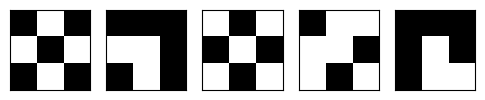

In [188]:
def draw_patterns(patterns, figsize=(6,4)):
  fig, ax = plt.subplots(nrows = 1, ncols = len(patterns), figsize=figsize)
  for i,p in enumerate(patterns):
    ax[i].imshow(patterns[i], cmap='Greys')
    ax[i].tick_params(axis='both', labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                             bottom=False, top=False, left=False, right=False)

draw_patterns(patterns)

Генерация обучающей и тестовой выборки

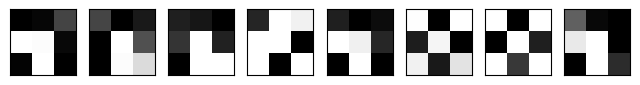

In [189]:
from sklearn.model_selection import train_test_split
N_SAMPLE_CLASS = 30
# N_SAMPLE_CLASS = 10
rng = np.random.default_rng()
X,y = [],[]
sigma = 0.15
for i_p,p in enumerate(patterns):
  for _ in range(N_SAMPLE_CLASS):
    X += [np.clip(p + sigma*rng.standard_normal(p.shape),0,1)]
    y += [i_p]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
draw_patterns(X_train[-8:], figsize=(8,5))

# Основные функции по созданию, обучению сети


Параметры

In [190]:
taum = 10*b2.ms
taue = 5*b2.ms
taui = 10*b2.ms
v_rest = -74*b2.mV
vt = -54*b2.mV
vr = -60*b2.mV
Ee = 0*b2.mV
Ei = -100*b2.mV

In [191]:
taupre=20*b2.ms
taupost=20*b2.ms
gmax=0.2
gmin=0.05
gi_max = gmax
max_delay_i = 10*b2.ms
dApre=0.01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

Основные функции для создания сети

In [192]:
def create_input_PG(size): # 1
  input_group = b2.PoissonGroup(size, rates=np.zeros(size)*b2.Hz, 
                              name='PG')  
  s_mon_inp = b2.SpikeMonitor(input_group)
  return input_group, s_mon_inp

def create_input_SGG(size): # 2
  input_group = b2.SpikeGeneratorGroup(size, indices = [],
                                       times=[]*b2.ms, name='SG')  
  s_mon_inp = b2.SpikeMonitor(input_group)
  return input_group, s_mon_inp

def create_exc_neurons(size):
  neuron_eq = '''
            dv/dt = (v_rest - v + ge * (Ee - v) + gi * (Ei - v)) / taum : volt
            dge/dt = -ge / taue : 1
            dgi/dt = -gi / taui : 1
            '''
  neurons = b2.NeuronGroup(size, neuron_eq, threshold='v>vt', reset='v = vr',
                      method='euler')
  neurons.v = v_rest
  neurons.ge=0
  neurons.gi=0
  s_mon_nrn = b2.SpikeMonitor(neurons)
  return neurons, s_mon_nrn


def create_stdp_synapses(pre_group, post_group):
  S = b2.Synapses(pre_group, post_group,
             '''w : 1
                stdp_rate : 1 (shared)
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + stdp_rate*Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + stdp_rate*Apre, 0, gmax)''',
             )
  S.connect()
  S.w = 'rand() * gmax'
  S.stdp_rate = 1
  mon = b2.StateMonitor(S, 'w', record=True)
  return S, mon

def create_inh_synapses(neuron_group):
    # тормозящие синапсы с задержкой   
  S = b2.Synapses(neuron_group, neuron_group,
             '''w : 1
                ''',
             on_pre='''gi += w''',
             )
  S.connect('i!=j')
  S.delay = "max_delay_i*rand()"
  S.w = gi_max  
  return S


In [193]:
%%time
def evaluate(X, total_time):
  img_spike_count = np.zeros((len(X), len(exc_layer)))
  T_show = 50*b2.ms
  rate_mon = b2.SpikeMonitor(exc_layer)
  prev_count = np.zeros((len(exc_layer),))
  for i_img, img in enumerate(X):
    times = total_time + encode_ttfs_inverse(img)
    input_layer.set_spikes(indices, times)
    b2.run(T_show, report=None)
    total_time += T_show
    img_spike_count[i_img,:] = np.array(rate_mon.count-prev_count)
    prev_count += img_spike_count[i_img,:]
    input_layer.set_spikes([], []*b2.ms)
    b2.run(T_rest, report=None)
    total_time += T_rest
    #del rate_mon
  return img_spike_count, total_time

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs


Определение класса

In [194]:
def predict(rates, neuron_class):
  y = np.ones(rates.shape[0])*np.nan
  for i,x in enumerate(rates):
    y[i] = neuron_class[np.argmax(x)]
  return y

Качество классификации

In [195]:
def all_metrics(prediction, y):
    print(f'Количество несовпадающих объектов {np.sum((prediction - y) != 0)} из {prediction.shape[0]} ({int(np.sum((prediction - y) != 0) / prediction.shape[0]*100)} %)')
    acc = round(accuracy_score(y, prediction),2)
    cm = confusion_matrix(y, prediction)
    cm_display = ConfusionMatrixDisplay(cm).plot()
#     cm = multilabel_confusion_matrix(y, prediction)
#     cm_display = ConfusionMatrixDisplay(cm).plot()
    f1 = round(f1_score(y, prediction, average='weighted'),2)
    mse = round(mean_squared_error(y, prediction,  squared=False),2)
    fbeta = round(fbeta_score(y, prediction,average='weighted', beta=0.5),2)
    hamming_loss_ = round(hamming_loss(y, prediction),2)
    print(f"Accuracy: {acc}")
    print(f"f_1: {f1}")
    print(f"mse: {mse}")
    print(f"fbeta: {fbeta}")
    print(f"fhamming_loss: {hamming_loss_}")
    return [acc,f1,mse,fbeta,hamming_loss_]

Прорисовывание весов

In [196]:
def plot_synapses(n_source, n_target, synapses, title=""):
  plt.figure(figsize=(3,3))
  W = np.full((n_source, n_target), np.nan)
  W[synapses.i[:], synapses.j[:]] = synapses.w[:]
  plt.imshow(W)
  plt.yticks(synapses.i)
  plt.xticks(synapses.j)
  plt.title(title)
  plt.xlabel("Target")
  plt.ylabel("Source")
  plt.colorbar(format="%4.2f")

def plot_input_synapses(synapses):
  #plt.figure(figsize=(16,5))
  fig,ax = plt.subplots(nrows=1, ncols=len(synapses.target)+1, figsize=(12,3))
  for j in range(len(synapses.target)):
    #W = np.full((3, 3), np.nan)
    #W[:, :] = 
    im = ax[j].imshow(np.reshape(synapses.w[:,j], (3,3)), vmin=0, vmax=1)
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].set_title(f"Neuron {j}")
  fig.colorbar(im, cax = ax[-1], format="%4.2f")

def plot_ins(input_layer, exc_layer, stdp_synapses, inh_synapses):
    print(f"Input layer: {len(input_layer)} neurons")
    print(f"Excitatory layer: {len(exc_layer)} neurons")
    print(f"{len(stdp_synapses)} STDP synapses")
    print(f"{len(inh_synapses)} inhibitory synapses")
    #plot_synapses(input_layer.N, exc_layer.N, stdp_synapses, "STDP weights")
    #plot_synapses(exc_layer.N, exc_layer.N, inh_synapses, "Inhibitory weights")
    plot_input_synapses(stdp_synapses)

In [197]:
def plot_info(mon_stdp, mon_input, mon_exc):
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(mon_stdp.t/b2.ms, mon_stdp.w.T/gmax)
    plt.xlabel('Time (s)')
    plt.ylabel('Weight / gmax')
    plt.subplot(412)
    plt.plot(mon_input.t/b2.ms, mon_input.i, '.k')
    plt.xlabel('Time (ms)')
    plt.ylabel('Input neuron')
    #plt.yticks(range(0,len(input_rates)))
    plt.subplot(413)
    plt.plot(mon_exc.t/b2.ms, mon_exc.i, '.k')
    plt.xlabel('Time (ms)')
    plt.ylabel('Output neuron')
    #plt.tight_layout()
    plt.show()
    #plot_synapses(input_layer.N, exc_layer.N, stdp_synapses, "STDP weights")

# Временное кодирование TTFS
Яркость пикселя $r_i$ преобразуется во время спайка по правилу

$$
t_i=1/r_i
$$

In [198]:
gmax = 0.6 #0.8 #0.6
gavg = 0.3 #0.2 # 0.3
gmin = 0.0001

## Создаем сеть

In [199]:
%%time
b2.start_scope()
input_layer, mon_input = create_input_SGG(patterns[0].size)
exc_layer, mon_exc = create_exc_neurons(5*len(patterns))
stdp_synapses, mon_stdp = create_stdp_synapses(input_layer, exc_layer)
stdp_synapses.w = change_w(stdp_synapses.w, patterns[0].size, [2]) 
inh_synapses = create_inh_synapses(exc_layer)
b2.run(0*b2.ms)
b2.store() 

CPU times: user 659 ms, sys: 25.9 ms, total: 685 ms
Wall time: 685 ms


Input layer: 9 neurons
Excitatory layer: 25 neurons
225 STDP synapses
600 inhibitory synapses


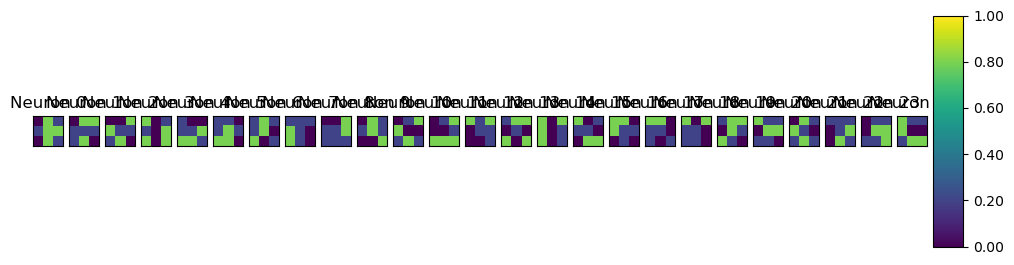

In [200]:
plot_ins(input_layer, exc_layer, stdp_synapses, inh_synapses)

## Обучение

WARNING    <timed exec>:9: RuntimeWarning: divide by zero encountered in divide
 [py.warnings]


Training STDP weights has finished!
CPU times: user 2min 56s, sys: 1.05 s, total: 2min 57s
Wall time: 2min 57s


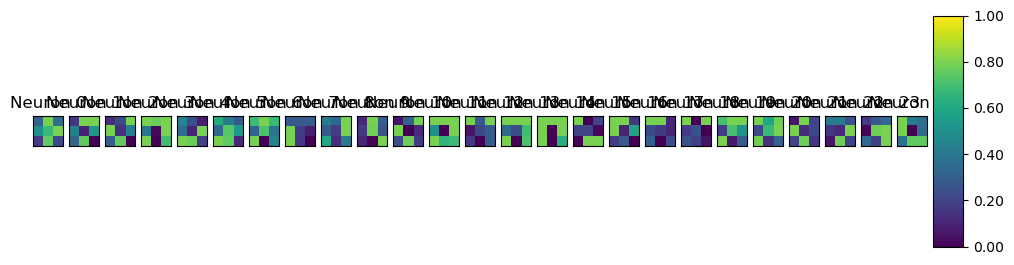

In [201]:
%%time
INF_TIME = 1000
t_min = 0.01*b2.ms
T_img = 50*b2.ms
T_rest = 30*b2.ms

indices = list(range(len(input_layer)))

def encode_ttfs_inverse(img):
  times = np.ones((img.size,))/img.ravel() 
  times[times==np.inf] = INF_TIME
  return np.ones((img.size,))*t_min + times*b2.ms

def train(X):
  total_time = 0*b2.ms
  for img in X:
    times = total_time + encode_ttfs_inverse(img) 
    input_layer.set_spikes(indices, times) 
    b2.run(T_img, report=None)
    total_time += T_img
    input_layer.set_spikes([], []*b2.ms)
    b2.run(T_rest, report=None)
    total_time += T_rest
  return total_time

b2.restore()
stdp_synapses.stdp_rate = 1
total_time = train(X)
print("Training STDP weights has finished!")
plot_input_synapses(stdp_synapses)

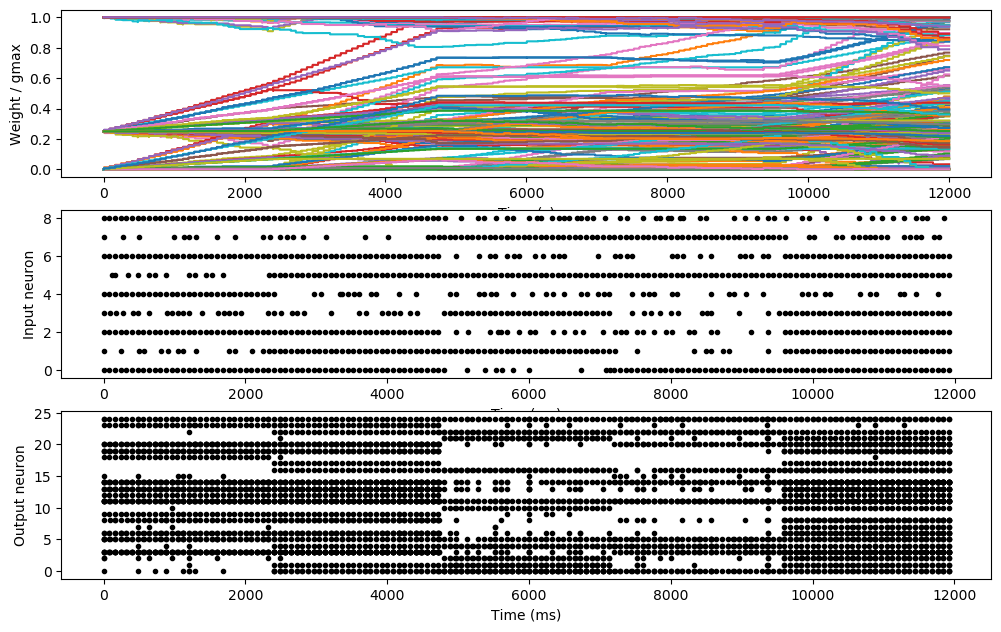

In [202]:
plot_info(mon_stdp, mon_input, mon_exc)

WARNING    <timed exec>:9: RuntimeWarning: divide by zero encountered in divide
 [py.warnings]


CPU times: user 2min 21s, sys: 982 ms, total: 2min 22s
Wall time: 2min 22s


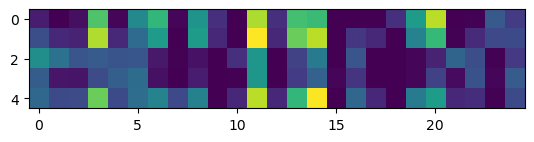

In [203]:
%%time
stdp_synapses.stdp_rate = 0
train_rates, total_time = evaluate(X_train, total_time)
nrn_class_count = np.zeros((len(patterns),len(exc_layer)))
for i_class in range(len(patterns)):
  nrn_class_count[i_class,:] = np.sum(train_rates[np.equal(y_train,i_class),:], axis=0)
plt.imshow(nrn_class_count)  
neuron_class = np.argmax(nrn_class_count, axis=0)

In [204]:
print(neuron_class)
print(train_rates)

[2 2 2 1 3 0 0 4 1 0 2 1 0 1 4 3 4 1 0 0 0 2 3 0 3]
[[1. 0. 1. ... 0. 2. 2.]
 [2. 1. 1. ... 1. 2. 2.]
 [0. 0. 0. ... 0. 2. 1.]
 ...
 [4. 3. 2. ... 2. 0. 1.]
 [4. 3. 2. ... 2. 0. 1.]
 [2. 1. 1. ... 1. 2. 2.]]


In [205]:
#metrics_history = []

# Проверка на обучающей выборке:

WARNING    <timed exec>:9: RuntimeWarning: divide by zero encountered in divide
 [py.warnings]


Количество несовпадающих объектов 49 из 120 (40 %)
Accuracy: 0.59
f_1: 0.57
mse: 1.15
fbeta: 0.62
fhamming_loss: 0.41
CPU times: user 2min 22s, sys: 1.47 s, total: 2min 23s
Wall time: 2min 24s


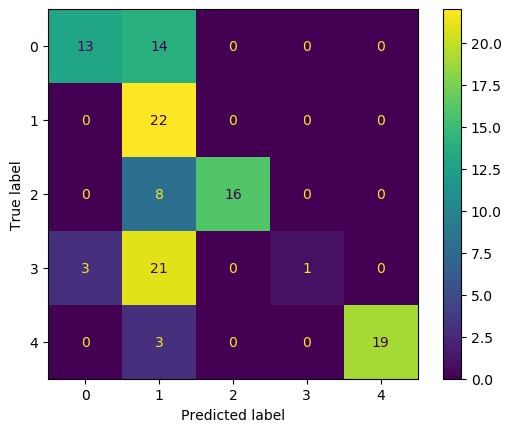

In [206]:
%%time
train_rates, total_time = evaluate(X_train, total_time)
train_prediction = predict(train_rates, neuron_class)
train = all_metrics(train_prediction, y_train)

# Проверка на тестовой выборке:

WARNING    <timed exec>:9: RuntimeWarning: divide by zero encountered in divide
 [py.warnings]


Количество несовпадающих объектов 8 из 30 (26 %)
Accuracy: 0.73
f_1: 0.69
mse: 1.02
fbeta: 0.69
fhamming_loss: 0.27
CPU times: user 35.4 s, sys: 208 ms, total: 35.6 s
Wall time: 35.6 s


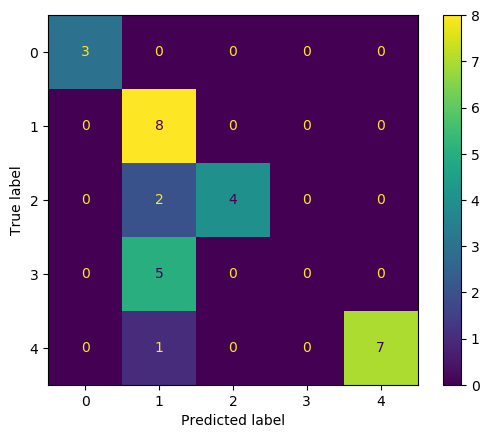

In [207]:
%%time
test_rates, total_time = evaluate(X_test, total_time)
test_prediction = predict(test_rates, neuron_class)
test = all_metrics(test_prediction, y_test)

# History of metrics 

In [208]:
metrics_history.append(['train', train, 'test', test])

In [209]:
metrics_history

[['train',
  [0.5166666666666667,
   0.44452955665024635,
   1.4112642086677698,
   0.5063273680610966,
   0.48333333333333334],
  'test',
  [0.3, 0.1965811965811966, 1.632993161855452, 0.2176706827309237, 0.7]],
 ['train',
  [0.5166666666666667,
   0.44452955665024635,
   1.4112642086677698,
   0.5063273680610966,
   0.48333333333333334],
  'test',
  [0.3, 0.1965811965811966, 1.632993161855452, 0.2176706827309237, 0.7]],
 ['train',
  [0.55, 0.5204287723528229, 0.9789450103725609, 0.554693803877107, 0.45],
  'test',
  [0.5666666666666667,
   0.5036291709666323,
   0.9128709291752769,
   0.4912008978675645,
   0.43333333333333335]],
 ['train',
  [0.4083333333333333, 0.33, 1.51, 0.34, 0.59],
  'test',
  [0.4, 0.29, 1.49, 0.27, 0.6]],
 ['train',
  [0.47, 0.34, 1.68, 0.33, 0.53],
  'test',
  [0.3, 0.19, 1.79, 0.21, 0.7]],
 ['train',
  [0.38, 0.23, 1.8, 0.19, 0.62],
  'test',
  [0.23, 0.11, 1.83, 0.08, 0.77]],
 ['train',
  [0.59, 0.57, 1.15, 0.62, 0.41],
  'test',
  [0.73, 0.69, 1.02, 0.69,

лучший результат акьюраси - 0.73